after 3d is completed, use model interface<br>

In [52]:
from numba import njit, prange
import numpy as np
import warnings
import xarray as xr
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [6]:
# @njit(parallel=True)
# def interpolate_speeds(speed_data, heights_data, target_heights_data):
#     n_times, n_levels, n_lat, n_lon = speed_data.shape
#     interpolated = np.empty((n_times, len(target_heights_data), n_lat, n_lon))
    
#     for i in prange(n_times):
#         for j in prange(len(target_heights_data)):
#             for k in prange(n_lat):
#                 for l in prange(n_lon):
#                     target = target_heights_data[l]
#                     # Find bracketing heights
#                     for m in prange(n_levels-1):
#                         if heights_data[m] <= target <= heights_data[m+1]:
#                             # Linear interpolation
#                             frac = (target - heights_data[m]) / (heights_data[m+1] - heights_data[m])
#                             interpolated[i, j, k, l] = speed_data[i, j, k, m] + frac * (speed_data[i, j, k, m+1] - speed_data[i, j, k, m])
#                             break
#     return interpolated

In [123]:
ds2 = xr.open_dataset('./sample.nc')

In [124]:
u = ds2['u']
v = ds2['v']
levels = ds2['level']

In [144]:
speed = np.sqrt(u**2 + v**2)

In [165]:
speed_loc1 = speed.values[0, :, 20, 20]

In [29]:
level_to_height = {
    131: 169.50,
    132: 136.62,
    133: 106.54,
    134: 79.04,
    135: 53.92,
    136: 30.96,
    137: 10
}

In [166]:
heights = np.array([level_to_height[int(l.values)] for l in levels])

In [113]:
# @njit(parallel=True)
# def interpolator(x, y_values, x_values=heights):
#     n = len(x_values)
#     result = 0.0
#     for i in range(n):
#         term = y_values[i]
#         for j in range(n):
#             if j != i:
#                 term = term * (x - x_values[j]) / (x_values[i] - x_values[j])
#         result += term
#     return result

In [167]:
target_height = np.linspace(10, 169.5, 10)

In [168]:
@njit(parallel=True)
def coef(y_values, x_values=heights):
    n = len(x_values)
    coef = np.zeros(n)

    for i in range(n):
        term = y_values[i]
        for j in range(n):
            if j != i:
                term = term / (x_values[i] - x_values[j])
        coef[i] = term

    return coef

In [169]:
@njit(parallel=True)
def interpolator(target, coef, x_values=heights):
    n = len(coef)
    result = 0.0
    for i in prange(n):
        term = coef[i]
        for j in prange(n):
            if j != i:
                term = term * (target - x_values[j])
        result += term
    return result

In [170]:
coefficients = coef(speed_loc1)

In [171]:
interpolated_speed1 = []
for h in target_height:
    interpolated_speed1.append(interpolator(h, coefficients))

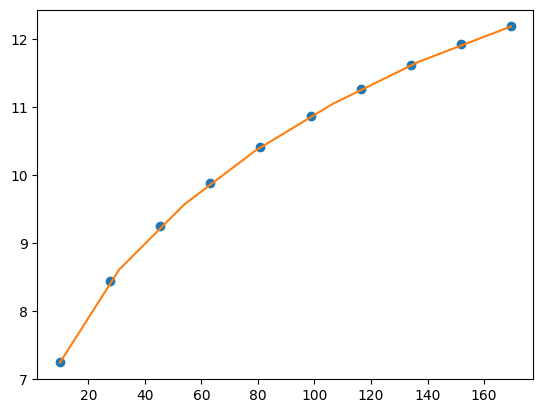

In [174]:
plt.plot(target_height, interpolated_speed1, 'o');
plt.plot(heights, speed_loc1);

### ERA5 Testing

In [8]:
import logging
logging.basicConfig(level=logging.INFO)
import geodata
from geodata.model.wind import WindInterpolationModel

In [9]:
DS = geodata.Dataset(
    module="era5",
    weather_data_config="wind_solar_hourly",
    years=slice(2005, 2005),
    months=slice(1,1),
    bounds=[50, -3, 45, 3]
)

2023-09-22 10:22:53,857 - geodata.dataset - INFO - Directory /Users/apple/.local/geodata/era5 found, checking for completeness.
2023-09-22 10:22:53,858 - geodata.dataset - INFO - Directory complete.


In [10]:
model = WindInterpolationModel(DS)
model.prepare()

2023-09-22 10:22:53,881 - geodata - INFO - The model is already prepared.


In [11]:
model.estimate(
    height=2,
    years=slice(2010, 2010),
    months=slice(1, 1)
)
# /Users/apple/.local/geodata/models/wind/era5/nc4/2005/01/05.params.nc4, 05 = date

[PosixPath('/Users/apple/.local/geodata/models/wind/era5/nc4/wind_solar_hourly.params.nc4'), PosixPath('/Users/apple/.local/geodata/era5/2005/01/wind_solar_hourly.nc')]


ValueError: Every dimension needs a coordinate for inferring concatenation order

In [ ]:
# def interpolate_wind_speed_cs(speed_data, heights, target_height):
#     cs = CubicSpline(heights, speed_data, axis=0)
#     interpolated_wind_speed = cs(target_height)
    
#     return interpolated_wind_speed

In [ ]:
# cs_speed = interpolate_wind_speed_cs(wind_speed[0, :, 0, 0], levels, 132.5)